Create plot for full ensemble of SLR projections for 3 SSPs

Ensemble contains a range of ESMs and ISMs

Computation is done with and without feedback

In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
ds = xr.open_dataset('../data/dummy.nc')
ds = ds.isel(exp=slice(0,5))
ds

<xarray.Dataset>
Dimensions:  (time: 150, esm: 14, ssp: 3, basin: 5, rftime: 150, exp: 5, ism: 6)
Coordinates:
  * time     (time) int64 1950 1951 1952 1953 1954 ... 2095 2096 2097 2098 2099
  * esm      (esm) object 'ACCESS-CM2' 'CAMS-CSM1-0' ... 'NorESM2-MM'
  * ssp      (ssp) object '126' '245' '585'
  * basin    (basin) object 'EAIS' 'ROSS' 'AMUN' 'WEDD' 'PENS'
  * rftime   (rftime) int64 0 1 2 3 4 5 6 7 ... 142 143 144 145 146 147 148 149
  * exp      (exp) object 'EAIS' 'ROSS' 'AMUN' 'WEDD' 'PENS'
  * ism      (ism) object 'CISM_NCA' 'GRIS_LSC' ... 'PISM_DMI' 'PISM_PIK'
Data variables:
    temp     (time, esm, ssp, basin) float64 ...
    orf      (rftime, exp, basin) float64 ...
    irf      (rftime, ism, basin) float64 ...
    srf      (rftime, ism, basin) float64 ...

In [3]:
def oce2ice(TMP,IRF,bm=8):
    #Input:
    #TMP: 5 temperature time series
    #IRF: Ice response function
    #bm: basal melt sensitivity [m/yr /degC]
    #Output:
    #IML: Ice mass loss for 5 regions [Gt/yr]
    assert TMP.shape == IRF.shape
    IML = 0.*TMP
    for t,tt in enumerate(IRF.rftime):
        if t==0: continue
        for b,bas in enumerate(IRF.basin):
            dFdt = TMP[1:t,b]-TMP[:t-1,b]
            CRF = IRF[1:t,b].values
            IML[t,b] = bm*np.sum(CRF*dFdt)
            #print(t,b,T[1:t,b].values,T[:t-1,b].values,dFdt)
            #print(t,b,dFdt,CRF,out[t,b].values)
    return IML

In [4]:
def oce2slr(TMP,SRF,bm=8):
    #Input:
    #TMP: 5 temperature time series
    #SRF: Sealevel response function
    #bm: basal melt sensitivity [m/yr /degC]
    #Output:
    #SLR: Cumulative sea level rise for 5 regions [m]
    assert TMP.shape == SRF.shape
    SLR = 0.*TMP
    for t,tt in enumerate(SRF.rftime):
        if t==0: continue
        for b,bas in enumerate(SRF.basin):
            dFdt = TMP[1:t,b]-TMP[:t-1,b]
            CRF = SRF[1:t,b].values
            SLR[t,b] = bm*np.sum(CRF*dFdt)
            #print(t,b,T[1:t,b].values,T[:t-1,b].values,dFdt)
            #print(t,b,dFdt,CRF,out[t,b].values)
    return np.cumsum(SLR,axis=0)

In [5]:
def ice2oce(IML,ORF):
    #Input:
    #IML: 5 ice mass loss time series
    #ORF: Ocean response function
    #Output:
    #TMP: Temperature anomaly for 5 regions [degC]
    assert IML.shape == ORF.shape[:2]
    assert ORF.shape[1] == ORF.shape[2]
    TMP = 0.*IML
    for t,tt in enumerate(ORF.rftime):
        if t==0: continue
        for e,ex in enumerate(ORF.exp):
            dFdt = IML[1:t,e]-IML[:t-1,e]
            for b,bas in enumerate(ORF.basin):
                CRF = ORF[1:t,e,b].values
                TMP[t,b] += np.sum(CRF*dFdt)
    return TMP

In [6]:
def iterate(tmp,orf,irf,srf,niter=10):
    TMP = np.zeros((niter,len(ds.time),len(ds.basin)))
    IML = np.zeros((niter,len(ds.time),len(ds.basin)))
    SLR = np.zeros((niter,len(ds.time),len(ds.basin)))
    TMP[0,:,:] = tmp.values
    IML[0,:,:] = oce2ice(TMP[0,:,:],irf)
    SLR[0,:,:] = oce2slr(TMP[0,:,:],srf)
    for n in range(1,niter):
        TMP[n,:,:] = tmp.values + ice2oce(IML[n-1,:,:],orf)
        IML[n,:,:] = oce2ice(TMP[n,:,:],irf)
        SLR[n,:,:] = oce2slr(TMP[n,:,:],srf)
    return TMP,IML,SLR

In [7]:
mpl.rcParams['lines.linewidth'] = 2.
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.titlesize'] = 9
mpl.rcParams['axes.labelsize'] = 9
mpl.rcParams['legend.fontsize'] = 9
mpl.rcParams['figure.subplot.wspace'] = .1
mpl.rcParams['figure.subplot.left'] = .1
mpl.rcParams['figure.subplot.right'] = .99
mpl.rcParams['figure.figsize'] = (7,3)

bcol = {}
bcol['EAIS'] = 'tab:blue'
bcol['ROSS'] = 'tab:orange'
bcol['AMUN'] = 'tab:red'
bcol['WEDD'] = 'tab:purple'
bcol['PENS'] = 'tab:green'

scol = {}
scol['119'] = (0/255,173/255,207/255)
scol['126'] = (23/255,60/255,102/255)
scol['245'] = (247/255,148/255,32/255)
scol['370'] = (231/255,29/255,37/255)
scol['585'] = (149/255,27/255,30/255)

126 ACCESS-CM2 CISM_NCA 0.12688998011842773 0.20124755809827727
126 ACCESS-CM2 GRIS_LSC 0.10492157198452179 0.19930768165523727
126 ACCESS-CM2 IMAU_VUB 0.09399559576191178 0.15205282435872192
126 ACCESS-CM2 ISSM_UCI 0.10430590205391964 0.18562887669005151
126 ACCESS-CM2 PISM_DMI 0.10310462600476551 0.19236644579001916
126 ACCESS-CM2 PISM_PIK 0.11411710028563782 0.19726504967327613
126 CAMS-CSM1-0 CISM_NCA 0.13730798538958752 0.21777051853312893
126 CAMS-CSM1-0 GRIS_LSC 0.11353591244680998 0.21567137306829431
126 CAMS-CSM1-0 IMAU_VUB 0.10171288448084342 0.16453676614975565
126 CAMS-CSM1-0 ISSM_UCI 0.11286969437539855 0.2008695017893029
126 CAMS-CSM1-0 PISM_DMI 0.11156979036365411 0.20816024325428123
126 CAMS-CSM1-0 PISM_PIK 0.12348641810880759 0.21346103556115892
126 CAS-ESM2-0 CISM_NCA 0.1171989249304891 0.18587754077974636
126 CAS-ESM2-0 GRIS_LSC 0.09690832504762192 0.18408581984630393
126 CAS-ESM2-0 IMAU_VUB 0.0868168058755733 0.14043999006741667
126 CAS-ESM2-0 ISSM_UCI 0.09633967609

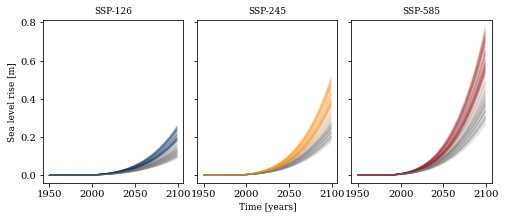

In [13]:
fig,ax = plt.subplots(1,3,sharex=True,sharey=True)

for s,ss in enumerate(ds.ssp.values):
    dax = ax[s]
    for e,es in enumerate(ds.esm.values):
        for i,ii in enumerate(ds.ism.values):
            TMP,IML,SLR = iterate(ds.temp.sel(ssp=ss,esm=es),ds.orf,ds.irf.sel(ism=ii),ds.srf.sel(ism=ii),niter=10)
            dax.plot(ds.time,np.sum(SLR[0,:,:],axis=1),c='.5',lw=1,alpha=.1)
            dax.plot(ds.time,np.sum(SLR[-1,:,:],axis=1),c=scol[ss],lw=1,alpha=.1)
            print(ss,es,ii,np.sum(SLR[0,-1,:]),np.sum(SLR[-1,-1,:]))
    dax.set_title(f'SSP-{ss}')

ax[0].set_ylabel('Sea level rise [m]')
ax[1].set_xlabel('Time [years]')

plt.savefig(f'../draftfigs/full_ensemble.png',dpi=450)
plt.show()